# Model testing

- It's just a testing ground for the model. One model is loaded and a `cmc.test_model` is applied on it.
- As a result confusion matrix, ROC, AUROC, F1, PR curves will be generated and saved to the model's folder

In [1]:
import os
from pathlib import Path
import confinement_mode_classifier as cmc
import torchvision
import torch
from tqdm import tqdm
import torch.nn as nn
import re
import pandas as pd
path = Path(os.getcwd())
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
ris_option = 'RIS1'
second_img_opt = None
num_workers = 32
batch_size = 32


In [3]:
shot_usage = pd.read_csv(f'{path}/data/shot_usage.csv')
shot_for_ris = shot_usage[shot_usage['used_for_ris1'] & shot_usage['used_for_ris2']]
shot_numbers = shot_for_ris['shot']
shots_for_testing = shot_for_ris[shot_for_ris['used_as'] == 'test']['shot']
shots_for_validation = shot_for_ris[shot_for_ris['used_as'] == 'val']['shot']
shots_for_training = shot_for_ris[shot_for_ris['used_as'] == 'train']['shot']
# #Testing specific shots
# shot_numbers = [17838, 17714, 19223]
# shots_for_testing = shot_numbers
# shots_for_validation = []

shot_df, test_df, val_df, train_df = cmc.load_and_split_dataframes(path, shot_numbers,
                                                                   shots_for_training, 
                                                                   shots_for_testing, 
                                                                   shots_for_validation, use_ELMS=False,
                                                                   ris_option=ris_option)

#Get dataloaders. second_img_opt='RIS1' indicates that two RIS1 models will be ensembled
test_dataloader = cmc.get_dloader(test_df, path=path, batch_size=batch_size,
                                   shuffle=False, balance_data=False, 
                                second_img_opt=second_img_opt, 
                                   num_workers=num_workers, augmentation=False)
test_dataloader_augmented = cmc.get_dloader(test_df, path=path, batch_size=batch_size,
                                   shuffle=False, balance_data=False, 
                                second_img_opt=second_img_opt, 
                                   num_workers=num_workers, augmentation=True)

### Load the model

In [4]:
#Initiate a single camera model
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1', )
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 2) #3 classes: L-mode, H-mode, ELM
pretrained_model = pretrained_model.to(device)

#Which model to test?
model_path = f'{path}/runs/24-03-17, 19-03-59 RIS1Testing augmentation with RIS1_last_fc'

#TEST one camera model
pretrained_model.load_state_dict(torch.load(f'{model_path}/model.pt'))
pretrained_model.eval()
pretrained_model.to(device)

#TEST ensembled model
# ensembled_model = cmc.TwoImagesModel(modelA=pretrained_model, modelB=pretrained_model, hidden_units=30).to(device)
# ensembled_model.load_state_dict(torch.load(f'{model_path}/model.pt'))
# ensembled_model.eval()
# ensembled_model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Test model on unbalanced test dset

Processing batches: 100%|██████████| 436/436 [02:40<00:00,  2.72it/s]


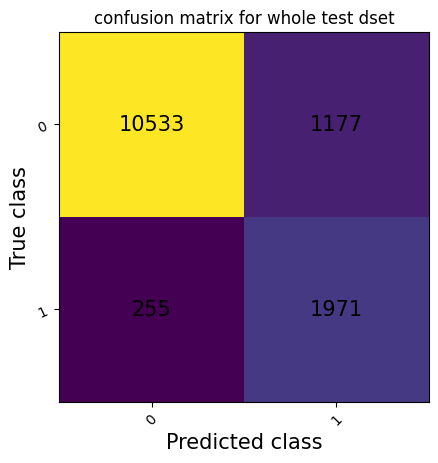

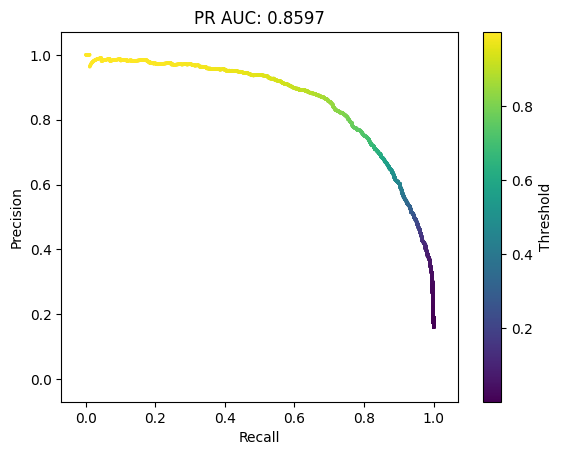

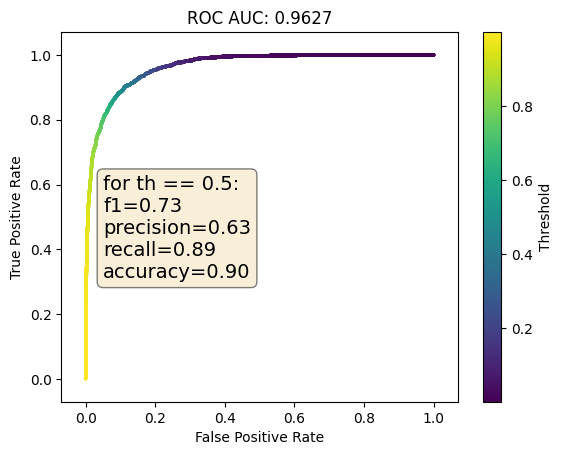

In [5]:
metrics = cmc.test_model(f'{path}/RIS1 preds for doubtful shots', pretrained_model, test_dataloader_augmented, max_batch=0, comment='augmented_last_fc')
#metrics = cmc.test_model(f'{path}/RIS1 preds for doubtful shots', pretrained_model, test_dataloader, max_batch=0, comment='original_last_fc')

### Here the model is tested on individual shots (generates time-confidence graph)

In [6]:
shots_for_testing = list(map(int,shots_for_testing))
#img_path = cmc.per_shot_test(path=f'{path}/RIS1 preds for doubtful shots', shots=shots_for_testing, results_df=metrics['prediction_df'])